In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
import category_encoders as ce
from sklearn.ensemble import StackingRegressor
from sklearn import tree
from xgboost import XGBRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_log_error
import math
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

pd.set_option("display.max_columns", None)

/kaggle/input/capetownhousingmodif/cape_town_data_modif.csv
/kaggle/input/cape-town-housing/cape_town_data.csv


# Problem Preparation

Chargement du fichier csv en pandas dataframe. 

A noter qu'on n'utilise pas ici le fichier original "property24_data.csv", mais un fichier légèrement modifié, "cape-town-housing-modif.csv", avec modifications de 3 lignes où, les quotes étaient mal placées pour que l'algorithme suivant fonctionne correctement.

Comme le fichier a une forme particulière, il a fallu un algorithme particulier pour charger le ficher. En voici les détails:
* lecture du fichier ligne par ligne,
* suppression des caractères de nouvelle ligne "\n",
* enregistrement de l'adresse, de la ville et de la région de chaque ligne dans une variable ,
* suppression de l'adresse, ville et de la région de la ligne,
* suppression des quotes,
* conversion de la ligne en liste et en dataframe,
* concatenation de toutes les dataframes,
* insertion de la colonne de l'adresse, ville et de la région

In [2]:
col = ["Bathrooms","Bedrooms","Erf Size","Floor Size","Garages","Listing Date","Listing Number","Pet Friendly","Price",
       "Type of Property","Garden","Pool","Secure Parking","Parking","No Pets Allowed","Furnished","Flatlet",
       "Fibre Internet","Furnished (Optional)","ADSL Internet","Satellite Internet","Fixed WiMax Internet"]
org_data = pd.DataFrame(columns=col)
Towns = []

# Dataset loading

with open ("../input/capetownhousingmodif/cape_town_data_modif.csv", "r") as myfile:
    lines = myfile.readlines()

for i in range(len(lines)):
    if i != 0:
        line = re.sub('\n', '', lines[i])
        town = re.search('(?<=\"")(.*?)(?=\"")', line)
        #print("Town : " , town.group(0))
        line = line.replace('""' + town.group(0) + '"",', '')
        Towns.append(town.group(0))
        line = re.sub('"', '', line)
        line = line.split(',')
        org_data = org_data.append(pd.DataFrame([line[:22]], columns=col), ignore_index=True)

In [3]:
org_data['Town'] = Towns
org_data.head()

,Bathrooms,Bedrooms,Erf Size,Floor Size,Garages,Listing Date,Listing Number,Pet Friendly,Price,Type of Property,Garden,Pool,Secure Parking,Parking,No Pets Allowed,Furnished,Flatlet,Fibre Internet,Furnished (Optional),ADSL Internet,Satellite Internet,Fixed WiMax Internet,Town
0,3.0,3.0,304 m²,326 m²,2.0,10 July 2020,108859219,1.0,6480000.0,House,,,,,,,,,,,,,"Tokai, Cape Town"
1,3.0,3.0,,140 m²,2.0,23 September 2020,109153971,1.0,6250000.0,Townhouse,,,,,,,,,,,,,"14 Graham Road, Sea Point, Cape Town"
2,3.5,4.0,659 m²,300 m²,2.0,23 September 2020,109154367,,13950000.0,House,1.0,1.0,2.0,,,,,,,,,,"Camps Bay, Cape Town"
3,1.0,2.0,,,,23 September 2020,109154455,,1050000.0,Apartment / Flat,,,,1.0,,,,,,,,,"Ottery, Cape Town"
4,1.0,1.0,,61 m²,,23 July 2020,108907258,,1265000.0,Apartment / Flat,,,1.0,,,,,,,,,,"Muizenberg, Cape Town"


# Data Summary

## Descriptive Stats

Dans cette première partie de "Data Summary", on applique des méthodes de statistiques descriptives aux données pour avoir un premier aperçu des données et des relations entre les caractéristiques
* quelques indicateurs statistiques
* corrélations entre caractéristiques
* Skewness ou inclinaison de chaque caractéristique

In [4]:
# View the first 20 rows of the data
org_data.head(20)

,Bathrooms,Bedrooms,Erf Size,Floor Size,Garages,Listing Date,Listing Number,Pet Friendly,Price,Type of Property,Garden,Pool,Secure Parking,Parking,No Pets Allowed,Furnished,Flatlet,Fibre Internet,Furnished (Optional),ADSL Internet,Satellite Internet,Fixed WiMax Internet,Town
0,3.0,3.0,304 m²,326 m²,2.0,10 July 2020,108859219,1.0,6480000.0,House,,,,,,,,,,,,,"Tokai, Cape Town"
1,3.0,3.0,,140 m²,2.0,23 September 2020,109153971,1.0,6250000.0,Townhouse,,,,,,,,,,,,,"14 Graham Road, Sea Point, Cape Town"
2,3.5,4.0,659 m²,300 m²,2.0,23 September 2020,109154367,,13950000.0,House,1.0,1.0,2.0,,,,,,,,,,"Camps Bay, Cape Town"
3,1.0,2.0,,,,23 September 2020,109154455,,1050000.0,Apartment / Flat,,,,1.0,,,,,,,,,"Ottery, Cape Town"
4,1.0,1.0,,61 m²,,23 July 2020,108907258,,1265000.0,Apartment / Flat,,,1.0,,,,,,,,,,"Muizenberg, Cape Town"
5,3.0,6.0,677 m²,,,18 September 2020,109136653,1.0,9900000.0,House,,,,8.0,,,,,,,,,"7 Breda Street, Oranjezicht, Cape Town"
6,3.5,3.0,,410 m²,2.0,24 July 2020,108909235,,55000000.0,Apartment / Flat,,1.0,,,1.0,,,,,,,,"Waterfront, Cape Town"
7,4.5,4.0,,300 m²,,23 September 2020,109154447,1.0,15999000.0,Apartment / Flat,,1.0,,2.0,,,,,,,,,"Sea Point, Cape Town"
8,1.0,1.0,,51 m²,,08 September 2020,109087490,,1385000.0,Apartment / Flat,,,,1.0,1.0,,,,,,,,"36 Clifford Ave, Vredehoek, Cape Town"
9,1.0,0.5,,43 m²,,07 September 2020,109072931,,1400000.0,Apartment / Flat,,1.0,,1.0,1.0,1.0,,,,,,,"Cape Town City Centre, Cape Town"


In [5]:
# data dimensions
org_data.shape

(7901, 23)

In [6]:
# Datatypes for each feature
org_data.dtypes

Bathrooms               object
Bedrooms                object
Erf Size                object
Floor Size              object
Garages                 object
Listing Date            object
Listing Number          object
Pet Friendly            object
Price                   object
Type of Property        object
Garden                  object
Pool                    object
Secure Parking          object
Parking                 object
No Pets Allowed         object
Furnished               object
Flatlet                 object
Fibre Internet          object
Furnished (Optional)    object
ADSL Internet           object
Satellite Internet      object
Fixed WiMax Internet    object
Town                    object
dtype: object

In [7]:
data_1 = org_data.copy()

In [8]:
data_1 = data_1.replace(r'^\s*$', np.nan, regex=True)

In [9]:
data_1.head()

,Bathrooms,Bedrooms,Erf Size,Floor Size,Garages,Listing Date,Listing Number,Pet Friendly,Price,Type of Property,Garden,Pool,Secure Parking,Parking,No Pets Allowed,Furnished,Flatlet,Fibre Internet,Furnished (Optional),ADSL Internet,Satellite Internet,Fixed WiMax Internet,Town
0,3.0,3.0,304 m²,326 m²,2.0,10 July 2020,108859219,1.0,6480000.0,House,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Tokai, Cape Town"
1,3.0,3.0,NaN,140 m²,2.0,23 September 2020,109153971,1.0,6250000.0,Townhouse,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"14 Graham Road, Sea Point, Cape Town"
2,3.5,4.0,659 m²,300 m²,2.0,23 September 2020,109154367,NaN,13950000.0,House,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Camps Bay, Cape Town"
3,1.0,2.0,NaN,NaN,NaN,23 September 2020,109154455,NaN,1050000.0,Apartment / Flat,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Ottery, Cape Town"
4,1.0,1.0,NaN,61 m²,NaN,23 July 2020,108907258,NaN,1265000.0,Apartment / Flat,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Muizenberg, Cape Town"


In [10]:
# Cast type of some columns
data_1['Bathrooms'] = data_1['Bathrooms'].astype(float, errors='ignore')
data_1['Bedrooms'] = data_1['Bedrooms'].astype(float)
data_1['Garages'] = data_1['Garages'].astype(float)
data_1['Listing Number'] = data_1['Listing Number'].astype(float)
data_1['Pet Friendly'] = data_1['Pet Friendly'].astype(float)
data_1['Parking'] = data_1['Parking'].astype(float)
data_1['No Pets Allowed'] = data_1['No Pets Allowed'].astype(float)
data_1['ADSL Internet'] = data_1['ADSL Internet'].astype(float)
data_1['Satellite Internet'] = data_1['Satellite Internet'].astype(float)
data_1['Fixed WiMax Internet'] = data_1['Fixed WiMax Internet'].astype(float)
data_1['Garden'] = data_1['Garden'].astype(float)
data_1['Pool'] = data_1['Pool'].astype(float)
data_1['Secure Parking'] = data_1['Secure Parking'].astype(float)
data_1['Price'] = data_1['Price'].astype(float)
data_1['Flatlet'] = data_1['Flatlet'].astype(float)
data_1['Fibre Internet'] = data_1['Fibre Internet'].astype(float)
data_1['Furnished (Optional)'] = data_1['Furnished (Optional)'].astype(float)
data_1['Furnished'] = data_1['Furnished'].astype(float)

In [11]:
data_1.dtypes

Bathrooms               float64
Bedrooms                float64
Erf Size                 object
Floor Size               object
Garages                 float64
Listing Date             object
Listing Number          float64
Pet Friendly            float64
Price                   float64
Type of Property         object
Garden                  float64
Pool                    float64
Secure Parking          float64
Parking                 float64
No Pets Allowed         float64
Furnished               float64
Flatlet                 float64
Fibre Internet          float64
Furnished (Optional)    float64
ADSL Internet           float64
Satellite Internet      float64
Fixed WiMax Internet    float64
Town                     object
dtype: object

### Convert values in ha to m²

In [12]:
data_1['Erf Size'].head(20)

0       304 m²
1          NaN
2       659 m²
3          NaN
4          NaN
5       677 m²
6          NaN
7          NaN
8          NaN
9          NaN
10         NaN
11    2 842 m²
12      645 m²
13    1 085 m²
14      252 m²
15         NaN
16      281 m²
17      209 m²
18         NaN
19         NaN
Name: Erf Size, dtype: object

In [13]:
def remove_unit(x):
    """Remove units ha or m² from string x"""
    if x != '0':
        x = x.replace(" ", "")
        x = x[:-2]
    return x

In [14]:
def convert_ha_to_m2(df, column):
    """Convert all values in ha in df[column] to m²"""
    ha_index = list(df[df[column].str.contains("ha", na=False)][column].index)
    df[column] = df[column].fillna('0')
    df[column] = df[column].apply(remove_unit)
    return ha_index

ha_index = convert_ha_to_m2(data_1, 'Erf Size')
data_1['Erf Size'] = data_1['Erf Size'].astype(float)
data_1.loc[ha_index, ['Erf Size']] = data_1.loc[ha_index, ['Erf Size']] * 10000

In [15]:
data_1['Erf Size'].head(10)

0    304.0
1      0.0
2    659.0
3      0.0
4      0.0
5    677.0
6      0.0
7      0.0
8      0.0
9      0.0
Name: Erf Size, dtype: float64

In [16]:
data_1.loc[ha_index, ['Erf Size']]

,Erf Size
2681,720000.0
3179,4950000.0
4276,94900000.0
4503,840000.0
5869,3010000.0
7742,4040000.0


In [17]:
ha_index_2 = convert_ha_to_m2(data_1, 'Floor Size')
data_1['Floor Size'] = data_1['Floor Size'].astype(float)
data_1.loc[ha_index_2, ['Floor Size']] = data_1.loc[ha_index_2, ['Floor Size']] * 10000

In [18]:
data_1['Erf Size'].replace(0., np.nan, inplace=True)
data_1['Floor Size'].replace(0., np.nan, inplace=True)

### Parsing date 

In [19]:
data_1['Listing Date'] = pd.to_datetime(data_1['Listing Date'], infer_datetime_format=True)

In [20]:
#Statistical summary
data_1.describe()

,Bathrooms,Bedrooms,Erf Size,Floor Size,Garages,Listing Number,Pet Friendly,Price,Garden,Pool,Secure Parking,Parking,No Pets Allowed,Furnished,Flatlet,Fibre Internet,Furnished (Optional),ADSL Internet,Satellite Internet,Fixed WiMax Internet
count,7812.000000,7661.000000,3.635000e+03,5869.000000,3732.000000,7.901000e+03,2026.0,7.846000e+03,2030.0,2738.0,666.000000,3423.000000,1319.0,299.0,414.0,795.0,22.0,40.0,12.0,1.0
mean,2.059908,2.615651,3.072695e+04,144.080763,1.641881,1.084730e+08,1.0,5.658831e+06,1.0,1.0,2.018018,1.887526,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
std,1.452088,1.629366,1.578416e+06,168.396558,0.921994,7.972524e+05,0.0,8.081759e+06,0.0,0.0,1.620259,1.749317,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
min,0.500000,0.500000,5.000000e+00,17.000000,1.000000,1.003926e+08,1.0,1.990000e+05,1.0,1.0,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
25%,1.000000,2.000000,1.665000e+02,61.000000,1.000000,1.082583e+08,1.0,1.850000e+06,1.0,1.0,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
50%,2.000000,2.000000,4.250000e+02,90.000000,1.000000,1.087737e+08,1.0,2.995000e+06,1.0,1.0,2.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
75%,2.500000,3.000000,7.900000e+02,162.000000,2.000000,1.089901e+08,1.0,5.990000e+06,1.0,1.0,2.000000,2.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
max,30.000000,33.000000,9.490000e+07,4029.000000,20.000000,1.091545e+08,1.0,1.725000e+08,1.0,1.0,15.000000,50.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


On a une première idée ici des données.
* On peut voir que beaucoup de colonnes ont des données manquantes
* On remarque aussi que les colonnes suivantes ont un grand écart entre le 75è quartile et la valeur maximale:
    * Bathrooms, Bedrooms, Erf Size, Floor Size, Garage, Price, Secure Parking, Parking

In [21]:
# Pairwise Pearson Correlations
print(data_1.corr(method='pearson'))

                      Bathrooms  Bedrooms  Erf Size  Floor Size   Garages  \
Bathrooms              1.000000  0.801156  0.032456    0.693075  0.518036   
Bedrooms               0.801156  1.000000  0.024708    0.650964  0.447563   
Erf Size               0.032456  0.024708  1.000000    0.254525  0.125320   
Floor Size             0.693075  0.650964  0.254525    1.000000  0.581723   
Garages                0.518036  0.447563  0.125320    0.581723  1.000000   
Listing Number        -0.141370 -0.073896  0.006688   -0.135424 -0.103038   
Pet Friendly                NaN       NaN       NaN         NaN       NaN   
Price                  0.596821  0.437259 -0.007885    0.678998  0.442069   
Garden                      NaN       NaN       NaN         NaN       NaN   
Pool                        NaN       NaN       NaN         NaN       NaN   
Secure Parking         0.541859  0.590233  0.222675    0.550429  0.468450   
Parking                0.422612  0.516976 -0.006044    0.550475  0.359716   

* On remarque ici qu'il y a une très forte corrélation entre certaines colonnes 
    * Bathrooms et Bedrooms corr > 0.8
    * Bathrooms et Floor Size corr > 0.69
    * Bedrooms et Floor Size corr > 0.65
    * Price et Floor Size corr > 0.67


In [22]:
# Skew for each feature
print(data_1.skew())

Bathrooms                3.822694
Bedrooms                 3.274795
Erf Size                59.796236
Floor Size               7.135220
Garages                  4.501643
Listing Number          -2.614363
Pet Friendly             0.000000
Price                    5.712808
Garden                   0.000000
Pool                     0.000000
Secure Parking           3.115331
Parking                  9.027897
No Pets Allowed          0.000000
Furnished                0.000000
Flatlet                  0.000000
Fibre Internet           0.000000
Furnished (Optional)     0.000000
ADSL Internet            0.000000
Satellite Internet       0.000000
Fixed WiMax Internet          NaN
dtype: float64


La colonne Erf Size semble être très inclinée

## Data visualization

Dans cette deuxième partie de la "Data Summary", on visualise les données pour avoir un meilleur aperçu des relations entre les caractéristiques et des particularité des données
* histogrammes
* boxplots
* tableau de corrélation
* scatterplots

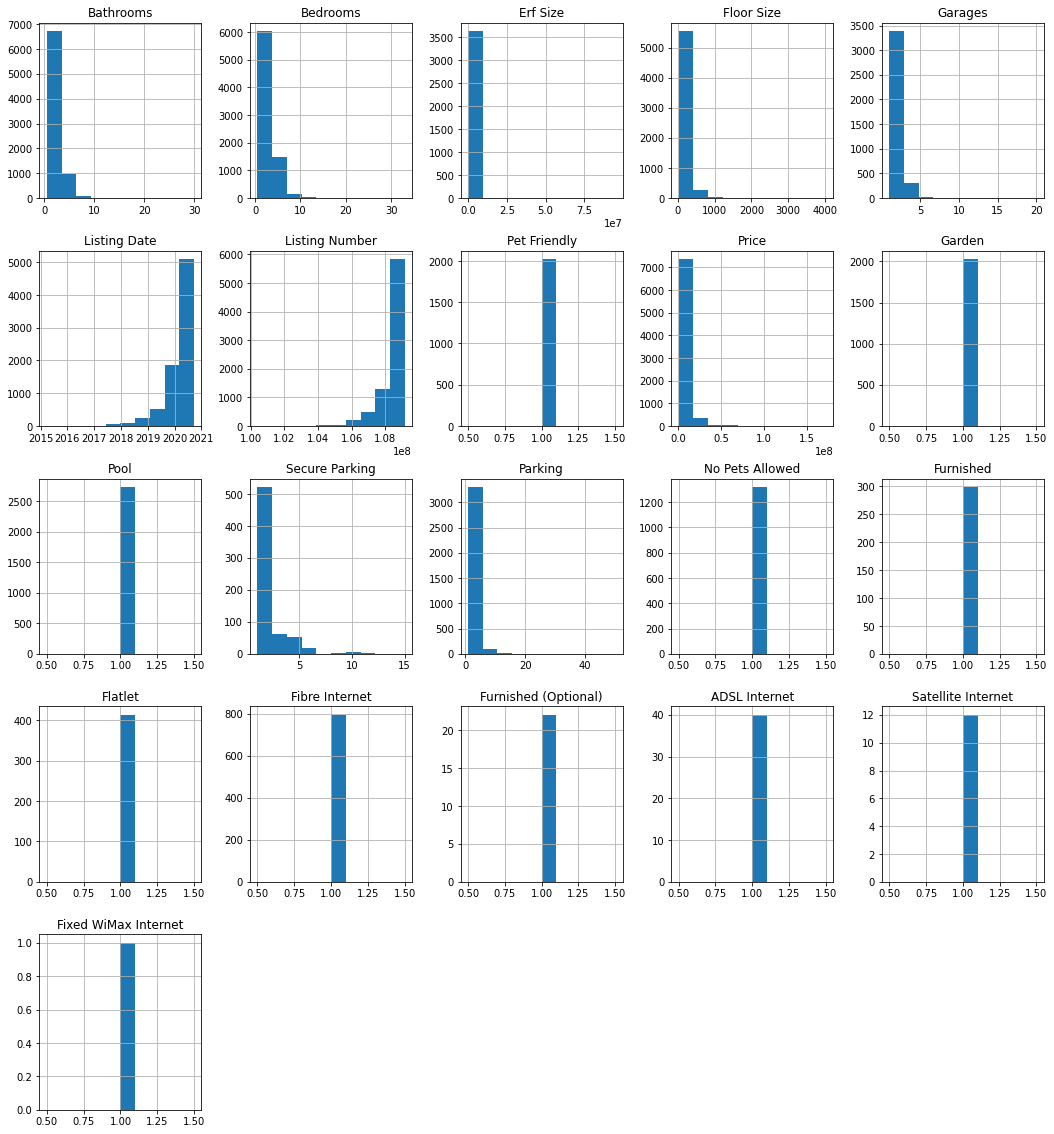

In [23]:
# Histograms
data_1.hist(figsize=(18,20))
plt.show()

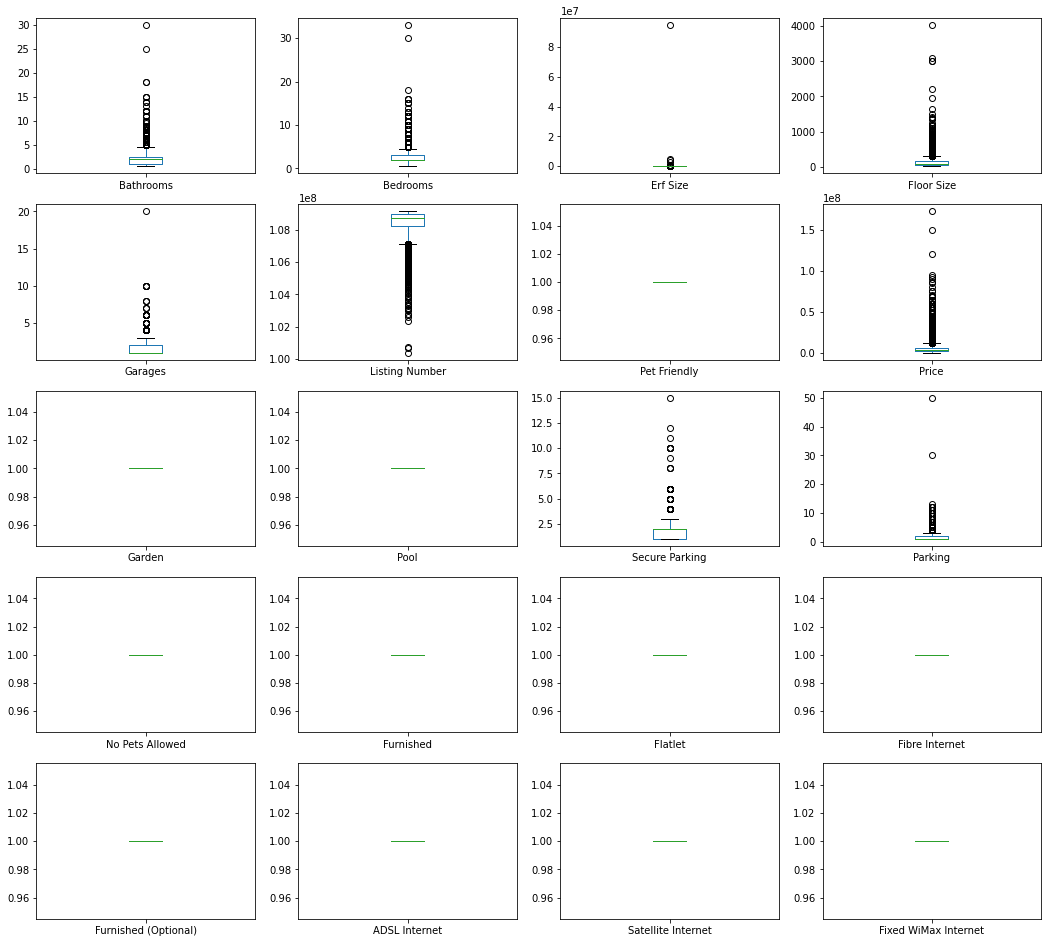

In [24]:
# Box plots
data_1.plot(kind='box', subplots=True, sharex=False, sharey=False, figsize=(18,20), layout=(6,4))
plt.show()

On remarque que beaucoup des colonnes à valeurs non booléens ont des beaucoup d'outliers. Heureusement, avec l'utilisation de la métrique RMSLE (Root Mean Squared Log Error), il n'y a aucun problème avec les outliers

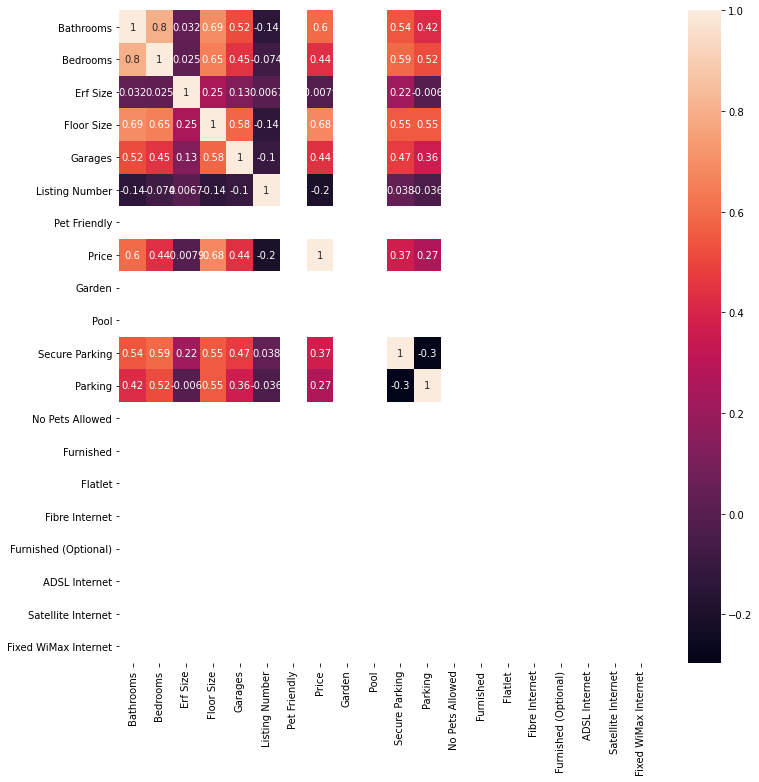

In [25]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(data_1.corr(), annot=True, ax=ax)
plt.show()

Cette matrice de corrélation confirme ce qui a été dit sur les colonnes fortement correlées : 
   * Bathrooms et Bedrooms corr > 0.8
   * Bathrooms et Floor Size corr > 0.69
   * Bedrooms et Floor Size corr > 0.65
   * Price et Floor Size corr > 0.67

Dans la suite, on va faire des scatterplots des colonnes fortement correlées pour confirmer les études statistiques fait ci-dessus

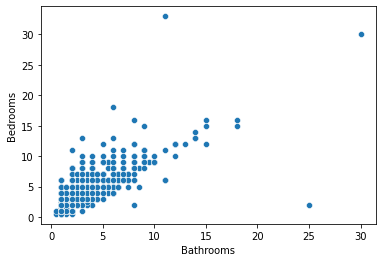

In [26]:
# Scatter plots
sns.scatterplot(data=data_1, x='Bathrooms', y='Bedrooms')
plt.show()

<AxesSubplot:xlabel='Bathrooms', ylabel='Price'>

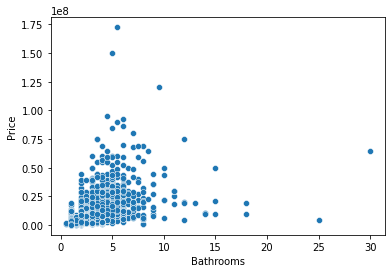

In [27]:
sns.scatterplot(data=data_1, x='Bathrooms', y='Price')

<AxesSubplot:xlabel='Floor Size', ylabel='Bathrooms'>

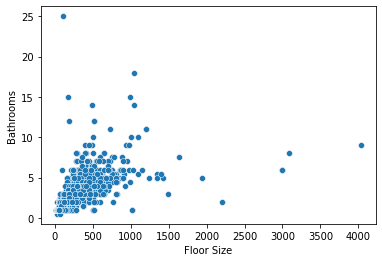

In [28]:
sns.scatterplot(data=data_1, y='Bathrooms', x='Floor Size')

<AxesSubplot:xlabel='Floor Size', ylabel='Bedrooms'>

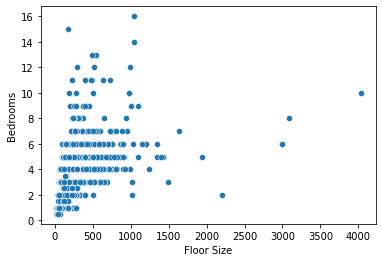

In [29]:
sns.scatterplot(data=data_1, y='Bedrooms', x='Floor Size')

<AxesSubplot:xlabel='Floor Size', ylabel='Price'>

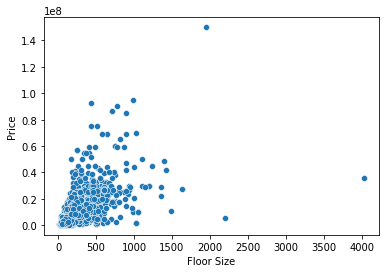

In [30]:
sns.scatterplot(data=data_1, y='Price', x='Floor Size')

# Splitting the data 

Division des données en données d'entrainement et données de test

In [31]:
data_2 = data_1.copy()

In [32]:
without_price = list(data_1[data_1['Price'].isna()].index)

In [33]:
data_2 = data_2.drop(index=without_price)

In [34]:
y = data_2.Price
X = data_2.copy()
del X['Price']

In [35]:
# Splitting the data into train data and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [36]:
print("X_train ", X_train.shape)
print("X_test ",X_test.shape)

X_train  (6276, 22)
X_test  (1570, 22)


# Data Preparation

Traitement des données:
* traintement des missing values
* encodage des valeurs catégorielles

In [37]:
X_train_1 = X_train.copy()
y_train_1 = y_train.copy()

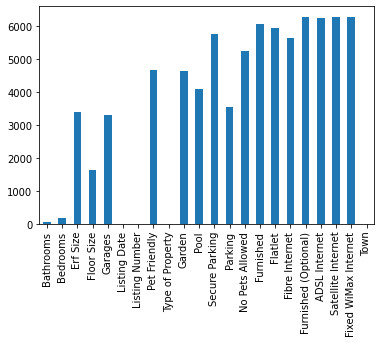

In [38]:
X_train_1.isna().sum().plot(kind='bar')
plt.show()

On a des valeurs manquantes dans toutes les colonnes sauf les colonnes Listing Date, Listing Number et Town

On remplace le contenu de Town par la ville où est localisée la maison / Appartement à vendre

In [39]:
def get_city(x):
    """Get the city from the column town and remove the address and the region"""
    x = x.split(",")
    if len(x) == 3:
        return x[1].replace(" ", "")
    elif len(x) == 2:
        return x[0].replace(" ", "")
    elif len(x) == 1:
        return x[0].replace(" ", "")
    
X_train_1['Town'] = X_train_1['Town'].apply(get_city)

Dans la suite, on va définir une pipeline pour transformer les données.

* Transformations des colonnes:
    * Bathrooms et Bedrooms: 
        * Les données manquantes sont peu nombreux
        * Logiquement, il n'y a pas de maison / appartement en vent sans bathrooms ni bedrooms
        * On va imputer la valeur des données manquantes avec les valeurs les plus fréquentes
    * Erf Size et Floor Size:
        * On a beaucoup d'outliers
        * On impute avec la valeur médiane au lieu de la moyenne
    * 'Garages', 'Pet Friendly',
       'Garden', 'Pool', 'Secure Parking', 'Parking', 'No Pets Allowed',
       'Furnished', 'Flatlet', 'Fibre Internet', 'Furnished (Optional)',
       'ADSL Internet', 'Satellite Internet', 'Fixed WiMax Internet':
        * Ce sont des colonnes à valeurs booléennes
        * On impute les valeurs manquantes avec 0
    * Type of Property:
        * Colonne catégorielle avec valeurs nominales
        * cardinalité = 3
        * On utilise One Hot Encoder pour encoder les variables
    * Town:
        * Colonne catégorielle avec valeurs nominales
        * Très grande cardinalité 
        * On va utiliser un "target value" encoder par l'utilisation de cat boost encoder pour éviter des problèmes de data leakage

In [40]:
# Preprocessing Bathrooms and Bedrooms features
bb_transformer = SimpleImputer(strategy='most_frequent')
bb_cols = ['Bathrooms', 'Bedrooms']

# Preprocessing Erf Size and Floor Size
size_transformer = SimpleImputer(strategy='median')
size_cols = ['Erf Size', 'Floor Size']

# Preprocessing boolean features
bool_transformer = SimpleImputer(strategy='constant')
bool_cols = ['Garages', 'Pet Friendly',
       'Garden', 'Pool', 'Secure Parking', 'Parking', 'No Pets Allowed',
       'Furnished', 'Flatlet', 'Fibre Internet', 'Furnished (Optional)',
       'ADSL Internet', 'Satellite Internet', 'Fixed WiMax Internet' ]

# Preprocessing Type of Property
top_transformer = OneHotEncoder(handle_unknown='ignore')
top_cols = ['Type of Property']

# Categorical variable Town encoding
cbe_encoder = ce.cat_boost.CatBoostEncoder()
cbe_cols = ['Town']

# Bundle all preprocessors
preprocessor = ColumnTransformer(
    remainder='passthrough',
    transformers=[
        ('bb_transformer', bb_transformer, bb_cols),
        ('size_transformer', size_transformer, size_cols),
        ('bool_transformer', bool_transformer, bool_cols),
        ('top_transformer', top_transformer, top_cols),
        ('cbe_encoder', cbe_encoder, cbe_cols)
    ])

# Training with all the features

Entrainement d'un modèle RandomForest avec toutes les caratéristiques

In [41]:
X_train_2 = X_train_1.copy()
y_train_2 = y_train_1.copy()

In [42]:
# Convert Date to numeric
import datetime as dt
X_train_2['Listing Date']=X_train_2['Listing Date'].map(dt.datetime.toordinal)

In [43]:
model_1 = RandomForestRegressor(n_estimators=100, random_state=0)

pipeline_1 = Pipeline(steps=[('preprocessor', preprocessor),
                             ('model', model_1)
                            ])
scores_1 = -1 * cross_val_score(pipeline_1, X_train_2, y_train_2, cv=10, 
                                scoring='neg_mean_squared_log_error')
print("Random Forest Model scores", scores_1)
print("Random Forest Model mean scores", scores_1.mean())

Random Forest Model scores [0.12668218 0.14423937 0.11831131 0.14154813 0.14861721 0.12737368
 0.11819169 0.13129806 0.13852331 0.14858858]
Random Forest Model mean scores 0.1343373504354258


In [44]:
print("Random Forest Model mean scores with RMSLE after training", math.sqrt(scores_1.mean()))

Random Forest Model mean scores with RMSLE after training 0.3665206002879317


In [45]:
X_test['Town'] = X_test['Town'].apply(get_city)
X_test['Listing Date'] = X_test['Listing Date'].map(dt.datetime.toordinal)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [46]:
pipeline_1.fit(X_train_2, y_train_2)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('bb_transformer',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Bathrooms', 'Bedrooms']),
                                                 ('size_transformer',
                                                  SimpleImputer(strategy='median'),
                                                  ['Erf Size', 'Floor Size']),
                                                 ('bool_transformer',
                                                  SimpleImputer(strategy='constant'),
                                                  ['Garages', 'Pet Friendly',
                                                   'Garden', 'Pool',
                                                   'Secure Parking', 'Parking',
                                                   'No

In [47]:
preds = pipeline_1.predict(X_test)
score_preds = mean_squared_log_error(y_test, preds)
print('Final Random Forest model score with RMSLE:', math.sqrt(score_preds))

Final Random Forest model score with RMSLE: 0.35049213781584937


Les scores de l'entrainement du modèle et de l'évaluation du modèle avec les données de test sont très proches. Le modèle ne fait pas d'overfitting 

### Random Forest hyperparameters tuning

Source - hyperparameters tuning: 
https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [48]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [49]:
model_1_1 = RandomForestRegressor()

pipeline_1_1 = Pipeline(steps=[('preprocessor', preprocessor),
                             ('model', model_1_1)
                            ])

X_train_2_1 = preprocessor.fit_transform(X_train_2, y_train_2)

cols = list(X_train_2.columns)

top = pipeline_1_1['preprocessor'].transformers_[3][1]\
                   .get_feature_names(top_cols)

cols.remove('Listing Date')
cols.remove('Listing Number')
cols.remove('Type of Property')
cols.remove('Town')
for i in top:
    cols.append(i)
cols.append('Town')
cols.append('Listing Date')
cols.append('Listing Number')

X_train_2_1 = pd.DataFrame(X_train_2_1, columns=cols)

In [50]:
# Random search of parameters, using 10 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = model_1_1, param_distributions = random_grid, n_iter = 100, 
                               cv = 10, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_2_1, y_train_2)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 29.5min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 54.3min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 81.4min finished


RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 288, 377, 466,
                                                         555, 644, 733, 822,
                                                         911, 1000]},
                   random_state=42, verbose=2)

In [51]:
rf_random.best_params_

{'n_estimators': 288,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

In [52]:
X_test_1_1 = preprocessor.fit_transform(X_test, y_test)
X_test_1_1 = pd.DataFrame(X_test_1_1, columns=cols)

In [53]:
best_random_model = rf_random.best_estimator_
random_preds = best_random_model.predict(X_test_1_1)
random_score = mean_squared_log_error(y_test, random_preds)
print("Final scores with hyperparameters tunned with randomizedsearch ", math.sqrt(random_score))

Final scores with hyperparameters tunned with randomizedsearch  0.4240848310580822


Le score obtenu après ajustement des hyperparamètres est encore assez élevé par rapport au premier modèle de Random Forest. Il s'impose alors de pousser un peu plus l'ajustement des hyperparamètres en les affinant en se basant sur les meilleurs hyperparamètres du randomized search ci-dessus.

In [54]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [90,100,110,120],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1,2,3],
    'min_samples_split': [2,4],
    'n_estimators': [1000, 1050, 1100, 1150]
}

grid_search = GridSearchCV(estimator = model_1_1, param_grid = param_grid, 
                          cv = 10, n_jobs = -1, verbose = 2)

In [55]:
grid_search.fit(X_train_2_1, y_train_2)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 30.2min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 53.0min
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed: 78.1min finished


GridSearchCV(cv=10, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [False], 'max_depth': [90, 100, 110, 120],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 4],
                         'n_estimators': [1000, 1050, 1100, 1150]},
             verbose=2)

In [56]:
grid_search.best_params_

{'bootstrap': False,
 'max_depth': 120,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 1050}

In [57]:
grid_preds = grid_search.best_estimator_.predict(X_test_1_1)
grid_score = mean_squared_log_error(y_test, grid_preds)
print("Final score with hyperparameters tunned with gridsearch ", math.sqrt(grid_score))

Final score with hyperparameters tunned with gridsearch  0.4261588906289102


Le score obtenu avec les hyperparamètres ajustés par grid search n'est toujours pas meilleur que le premier score du premier modèle Random Forest

### Conclusion
Comme les scores ne  s'améliorent pas avec l'ajustement des hyperparamètres, comme perspective d'amélioration pour le score, il serait plus intéressant de voir un autre modèle 

# Feature Selection

Sélections des features vraiment importants dans les données avec l'utilisation d'ExtraTreesClassifier

In [58]:
# Preprocess data
X_train_3 = preprocessor.fit_transform(X_train_2, y_train_2)

# ExtraTreeClassifier Model
extra_tree = ExtraTreesClassifier()

# Pipeline
pipeline_2 = Pipeline(steps=[('preprocessor', preprocessor),
                             ('model', extra_tree)
                            ])
pipeline_2.fit(X_train_2, y_train_2)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('bb_transformer',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Bathrooms', 'Bedrooms']),
                                                 ('size_transformer',
                                                  SimpleImputer(strategy='median'),
                                                  ['Erf Size', 'Floor Size']),
                                                 ('bool_transformer',
                                                  SimpleImputer(strategy='constant'),
                                                  ['Garages', 'Pet Friendly',
                                                   'Garden', 'Pool',
                                                   'Secure Parking', 'Parking',
                                                   'No

In [59]:
print(extra_tree.feature_importances_)

[5.95991947e-02 5.96723702e-02 8.36606172e-02 1.33758063e-01
 4.65172562e-02 1.41550622e-02 2.01756255e-02 1.05216754e-02
 1.82283726e-02 5.66767277e-02 1.30674415e-02 6.73318301e-03
 5.94400215e-03 1.36043061e-02 1.34994356e-03 2.19783774e-03
 7.45700921e-04 9.98468146e-05 2.34289573e-03 2.03238711e-03
 1.72035598e-03 1.48841100e-01 1.47533714e-01 1.50822321e-01]


Les features ayant les scores les plus grands sont les plus importants du dataset.  

In [60]:
importances = np.array(extra_tree.feature_importances_)
arg_importances = np.argsort(importances)
print(arg_importances)

[17 16 14 20 19 15 18 12 11  7 10 13  5  8  6  4  9  0  1  2  3 22 21 23]


In [61]:
cols = list(X_train_2.columns)

top = pipeline_2['preprocessor'].transformers_[3][1]\
                   .get_feature_names(top_cols)

cols.remove('Listing Date')
cols.remove('Listing Number')
cols.remove('Type of Property')
cols.remove('Town')
for i in top:
    cols.append(i)
cols.append('Town')
cols.append('Listing Date')
cols.append('Listing Number')

X_train_4 = pd.DataFrame(X_train_3, columns=cols)
print(X_train_4.head())

   Bathrooms  Bedrooms  Erf Size  Floor Size  Garages  Pet Friendly  Garden  \
0        4.5       3.0     433.0       418.0      2.0           0.0     1.0   
1        1.5       2.0     433.0        57.0      0.0           1.0     0.0   
2        1.5       3.0     433.0       109.0      1.0           0.0     0.0   
3        3.0       4.0     403.0        90.0      1.0           1.0     1.0   
4        1.5       3.0     433.0        87.0      0.0           0.0     0.0   

   Pool  Secure Parking  Parking  No Pets Allowed  Furnished  Flatlet  \
0   0.0             0.0      3.0              0.0        0.0      0.0   
1   1.0             2.0      0.0              0.0        0.0      0.0   
2   0.0             0.0      0.0              0.0        0.0      0.0   
3   0.0             2.0      0.0              0.0        0.0      0.0   
4   0.0             0.0      1.0              1.0        0.0      0.0   

   Fibre Internet  Furnished (Optional)  ADSL Internet  Satellite Internet  \
0       

Ici, on ne va garder que les 10 colonnes les plus importantes

In [62]:
# On ne garde que les 10 colonnes les plus importantes
arg_importances_sorted = arg_importances[14:][::-1]

X_train_5 = X_train_4.iloc[:, arg_importances_sorted]
y_train_5 = y_train_2.copy()

Voici les 10 colonnes (features) les plus importantes du dataset

In [63]:
X_train_5.columns

Index(['Listing Number', 'Town', 'Listing Date', 'Floor Size', 'Erf Size',
       'Bedrooms', 'Bathrooms', 'Parking', 'Garages', 'Garden'],
      dtype='object')

# Training for selected features

On utilise un stacked modèle (modèle empilé) pour avoir une meilleure performance des modèles suivants:
* Ridge
* Lasso
* Linear Regression
* XGboost
* RandomForest

In [64]:
r_forest = RandomForestRegressor(n_estimators=100, random_state=1)
ridge = Ridge()
linear = LinearRegression()
lasso = Lasso()
xgboost_model = XGBRegressor()

In [65]:
estimators = [
    ('linear regression', linear),
    ('ridge', ridge),
    ('lasso', lasso),
    ('XGboost', xgboost_model)
]

reg = StackingRegressor(estimators=estimators,
                        final_estimator=r_forest)


In [66]:
final_scores = -1 * cross_val_score(reg, X_train_5, y_train_5, cv=10, 
                                scoring='neg_mean_squared_log_error')
print("Final scores", final_scores)
print("Final score mean", final_scores.mean())

Final scores [0.28586884 0.25622297 0.19834971 0.180302   0.21826174 0.19806928
 0.16895571 0.18352571 0.1861243  0.19944539]
Final score mean 0.20751256528784853


In [67]:
print("Final score with RMSLE", math.sqrt(final_scores.mean()))

Final score with RMSLE 0.4555354709436451


In [68]:
X_test_1 = preprocessor.fit_transform(X_test, y_test)
X_test_1 = pd.DataFrame(X_test_1, columns=cols)
X_test_1 = X_test_1.loc[:, X_train_5.columns]

In [69]:
reg.fit(X_train_5, y_train_5)

StackingRegressor(estimators=[('linear regression', LinearRegression()),
                              ('ridge', Ridge()), ('lasso', Lasso()),
                              ('XGboost',
                               XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,


In [70]:
final_preds = reg.predict(X_test_1)

In [71]:
final_score_preds = mean_squared_log_error(y_test, final_preds)
print("Final scores with RMSLE", math.sqrt(final_score_preds))

Final scores with RMSLE 0.5022299204118492


### Conclusion
Le score n'est toujours pas meilleur que celui de notre base modèle Random Forest du début. Cela peut vouloir dire qu'on a une meilleure prediction avec tous les features présents car on a plus d'informations sur lesquelles basées nos prédictions

# Interpretable model

Nous allons utiliser un modèle Decision tree ici pour l'interprétabilité de ce modèle

Source: https://www.kaggle.com/gauravduttakiit/hyperparameter-tuning-in-decision-trees

In [72]:
dt = DecisionTreeClassifier(max_depth=3)

scores_dt = -1 * cross_val_score(dt, X_train_4, y_train_2, cv=10, 
                                scoring='neg_mean_squared_log_error')
print("Decision Tree scores", scores_dt)
print("Decision Tree mean score", scores_dt.mean())
print("Decision Tree mean score with RMSLE after training", math.sqrt(scores_dt.mean()))

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


Decision Tree scores [0.33410172 0.37087796 0.33437111 0.34009378 0.31953229 0.30553284
 0.34724392 0.32604103 0.31372271 0.30370336]
Decision Tree mean score 0.32952207272312134
Decision Tree mean score with RMSLE after training 0.5740401316311616


Comme attendu, le score n'est pas très bon. Par contre, avec le graphe ci-dessous, il est très facile de comprendre ce qui se passe avec l'arbre de décision

In [73]:
dt.fit(X_train_4, y_train_2)

DecisionTreeClassifier(max_depth=3)

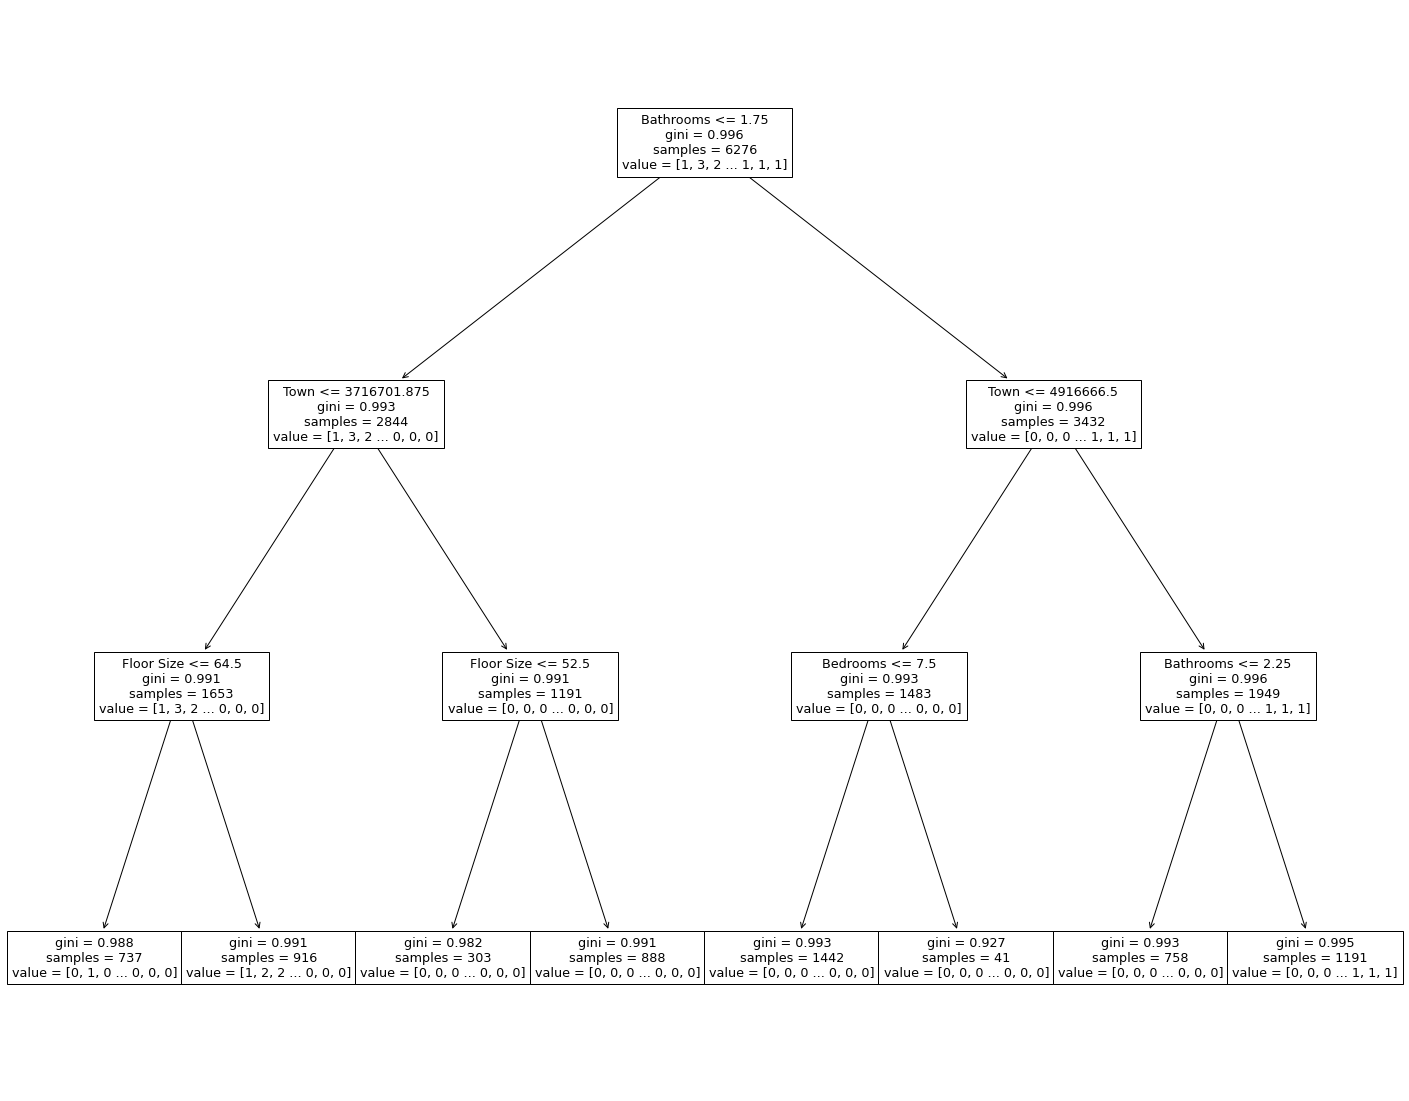

In [74]:
from sklearn import tree

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dt,
                   feature_names=X_train_4.columns)

### Decision Tree Hyperparameters tuning

In [75]:
dt_2 = DecisionTreeClassifier(random_state=42)
 
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

grid_search_tree = GridSearchCV(estimator = dt_2, param_grid = params, 
                          cv = 10, n_jobs = -1, verbose = 2)

In [76]:
grid_search_tree.fit(X_train_4, y_train_2)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 469 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.3min finished


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100]},
             verbose=2)

In [77]:
grid_search_tree.best_params_

{'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 5}

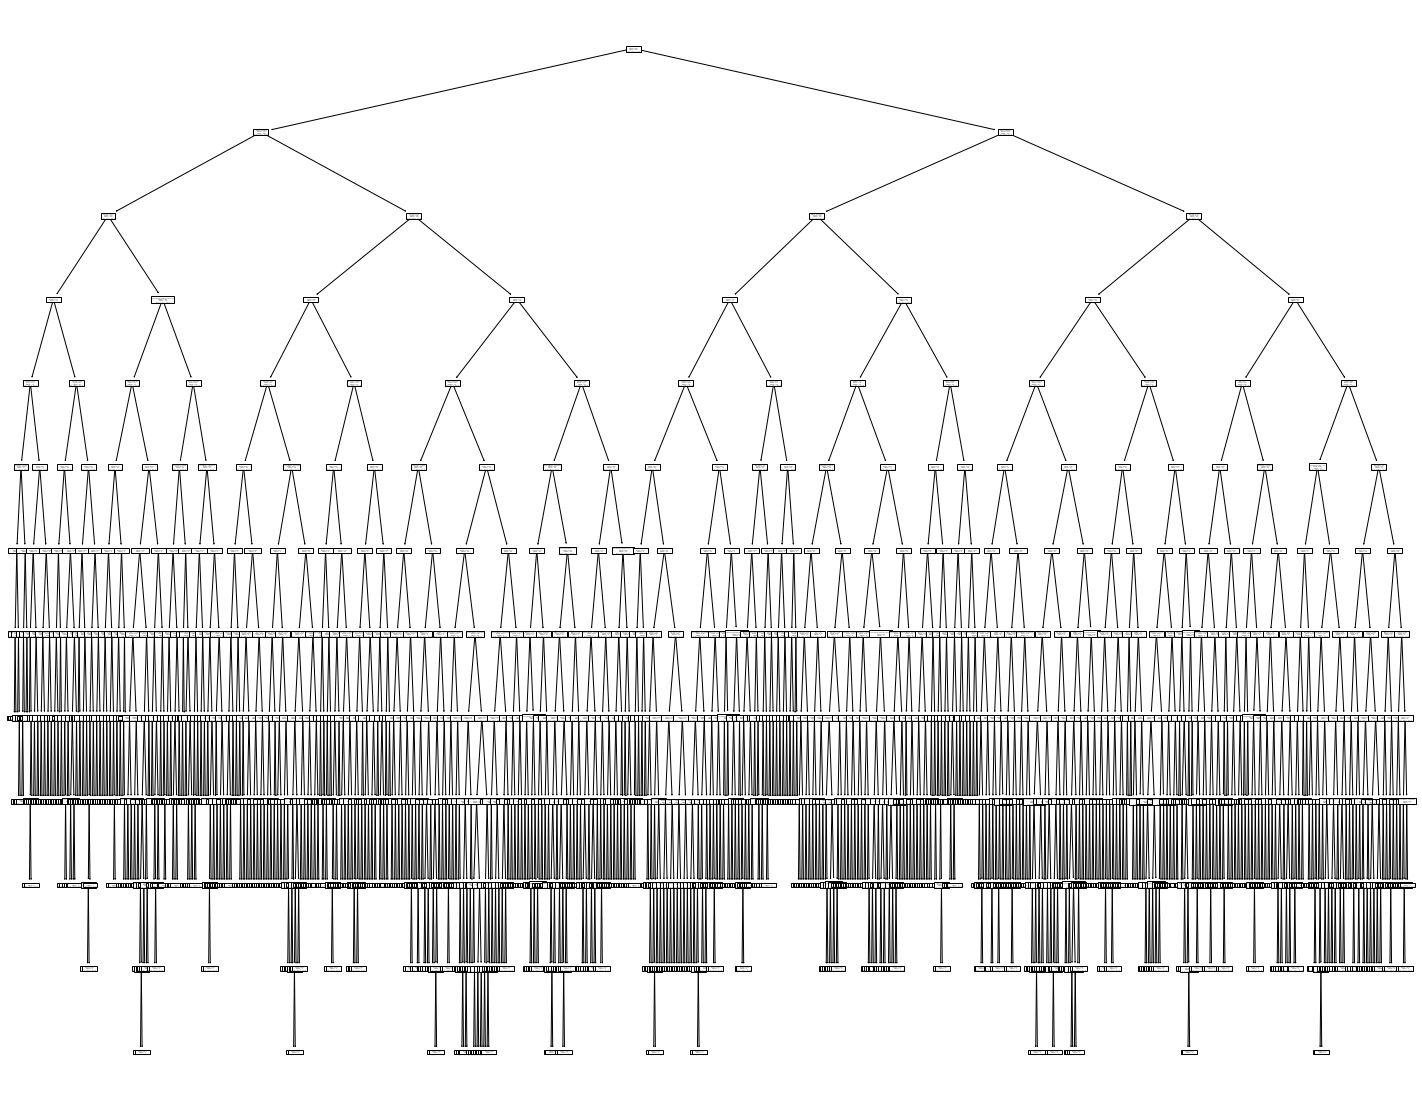

In [78]:
fig2 = plt.figure(figsize=(25,20))
_ = tree.plot_tree(grid_search_tree.best_estimator_,
                   feature_names=X_train_4.columns)

In [79]:
grid_preds_tree = grid_search_tree.best_estimator_.predict(X_test_1_1)
grid_score_tree = mean_squared_log_error(y_test, grid_preds_tree)
print("Final score with hyperparameters tunned with gridsearch ", math.sqrt(grid_score_tree))

Final score with hyperparameters tunned with gridsearch  0.6849773632780527
